# EDA tablas de reviews

---


Tras un analisis de las distintas tablas de datos que se nos brinda para nuestro modelo, llegamos a la conclusion que las mismas poseen una estructura de datos similar, por lo que podremos hacer un analisis exploratorio de los datos a cada una de las tablas utilizando la misma formula.

### Importacion de librerias

In [1]:
import pandas as pd #utilizaremos pandas para trabajar con las tablas de datos de una manera mas comoda
import numpy as np #importamos numpy para un mejor manejo de matrizes, filas y valores
import matplotlib.pyplot as plt #esta libreria la usaremos para graficar
from pyspark.sql import SparkSession #PySpark sera nuestra opcion para el manejo de grandes volumenes de datos

# Crea una sesión de Spark
spark = (SparkSession
   .builder
   .master('local[*]') # add this
   .appName("eda_reviews")
   .config("spark.hadoop.fs.hdfs.impl", "org.apache.hadoop.fs.LocalFileSystem")
   .getOrCreate())


# Importamos las funciones de sql de pyspark para manejar mejor las columnas
from pyspark.sql.functions import col, sum, when, size, length, to_date, from_unixtime, year, count, udf


## PASO 1: Extraer tabla de datos

In [2]:
# Creamos un dataframe con el archivo Digital_music.json
df = spark.read.json('../datasets/Digital_Music.json')


Una vez importado damos un breve vistazo a nuestra tabla y chequeamos la cantidad de filas

In [3]:
print(df.count())
df.show(10)

1584082
+----------+-----+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|       reviewerName|               style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+
|0001388703| NULL|    5.0|This is a great c...|12 22, 2013|A1ZCPG3D3HGRSS|     mark l. massey|{NULL,  Audio CD,...|    Great worship cd|    1387670400|    true|NULL|
|0001388703| NULL|    5.0|So creative!  Lov...|09 11, 2013| AC2PL52NKPL29|       Norma Mushen|{NULL,  Audio CD,...|Gotta listen to t...|    1378857600|    true|NULL|
|0001388703| NULL|    5.0|Keith Green, gone...| 03 2, 2013|A1SUZXBDZSDQ3A| Herbert W. Shurley|{NULL,  Audio CD,...|Great approach st...|    1362182400|    true|NU

## PASO 2: Tratamiento de duplicados.
---

In [4]:
num_filas_duplicadas = df.count() - df.dropDuplicates().count()

# Imprime el número de filas duplicadas
print("Número de filas duplicadas:", num_filas_duplicadas)
print(f"Porcentaje de filas duplicadas: {num_filas_duplicadas / df.count()}")


Número de filas duplicadas: 64503
Porcentaje de filas duplicadas: 0.040719482956059094


Procedemos a eliminar las filas duplicadas ya que estas mismas tienen los valores de cada columna similar a una fila que ya existe, ya sea ID, puntaje e incluso texto de la review

In [5]:
df = df.dropDuplicates()

## paso 3: manejo de columnas y faltantes.
---

In [6]:
df.show(10)

+----------+-----+-------+--------------------+-----------+--------------+----------------+--------------------+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|    reviewerName|               style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+----------------+--------------------+--------------------+--------------+--------+----+
|B000V6AEI6| NULL|    5.0|The composistions...| 01 1, 2004| AAVK0CAPD9XH5|            mole|{NULL,  Audio CD,...|Fantastic musik a...|    1072915200|   false|NULL|
|B000VRWV4U| NULL|    5.0|I needed some sca...| 01 1, 2013|A3O39R049OZZUZ|           Wonka|{NULL,  MP3 Music...|     halloween Music|    1356998400|    true|NULL|
|B000TE3FBS| NULL|    1.0|never received it...| 01 1, 2014| A19CD6KQG33SD|           Dixie|{NULL,  MP3 Music...|               !!!!!|    1388534400|    true|NULL|
|B0048W3SQ4| NULL|    

In [7]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)



Observamos que la mayoria de los datos son de tipo string, que por cierto estan en el tipo de dato que se necesita, pero podemos buscar las filas con valores faltantes sin que sean nulos de por si, por ello haremos lo siguiente

In [8]:
columnas_string_a_verificar = ["asin", "reviewText", "reviewerID", "reviewerName"]

# Verifica si las columnas string están vacías y las marca como nulas si es necesario
for columna in columnas_string_a_verificar:
    df = df.withColumn(columna, when((length(col(columna)) == 0) | (col(columna).isNull()), None).otherwise(col(columna)))
    

con el codigo anterior convertimos todas las filas de tipo string vacias en valores nulos, para ahora poder observar que valores nos faltan

In [9]:
# Calcula la cantidad de nulos por columna
conteo_de_nulos_por_columna = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Muestra el resultado
conteo_de_nulos_por_columna.show()

+----+-------+-------+----------+----------+----------+------------+------+-------+--------------+--------+-------+
|asin|  image|overall|reviewText|reviewTime|reviewerID|reviewerName| style|summary|unixReviewTime|verified|   vote|
+----+-------+-------+----------+----------+----------+------------+------+-------+--------------+--------+-------+
|   0|1513041|      0|      1417|         0|         0|          78|261637|    523|             0|       0|1398474|
+----+-------+-------+----------+----------+----------+------------+------+-------+--------------+--------+-------+



A priori podemos observar varias columnas que no nos serviran para nuestro sistema de recomendaciones, por lo que procedemos a eliminarlas de una vez, estas columnas serian:
- image: porque no nos interesa la imagen del producto
- style: por la gran cantidad de valores nulos y la poca relevancia que da
- summary: ya que es un resumen de reviewText, por lo que con nuestro sistema no nos haria falta ver el resumen
- vote: por su gran cantidad de valores nulos y porque ya tenemos la columna overall, que nos indica el voto de la review
- reviewTime: Ya que posee valores nulos y con la columna unixReviewTime podemos lograr los mismos fines

In [10]:
columnas_a_eliminar = ["image", "style", "summary", 'vote', 'reviewTime']

df = df.drop(*columnas_a_eliminar)

Por otro lado podemos eliminar los valores nulos de las siguientes columnas:
- reviewText: ya que sin el texto de la review no nos sirve el resto de informacion
- reviewerName: porque al tampoco poder identificar al usuario nos podria crear problemas al crear nuestro modelo

In [11]:
df = df.na.drop(subset=["reviewText"])
df = df.na.drop(subset=["reviewerName"])
df_actualizado = df.na.fill("N/D", ['reviewerName'])

In [12]:
# Calcula la cantidad de nulos por columna
conteo_de_nulos_por_columna = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Muestra el resultado
conteo_de_nulos_por_columna.show()

+----+-------+----------+----------+------------+--------------+--------+
|asin|overall|reviewText|reviewerID|reviewerName|unixReviewTime|verified|
+----+-------+----------+----------+------------+--------------+--------+
|   0|      0|         0|         0|           0|             0|       0|
+----+-------+----------+----------+------------+--------------+--------+



Ahora si nos quedamos sin valores nulos por lo que podemos seguir:

## Paso 4: Transformaciones de columnas y tipos de datos.
---

En primer lugar recordamos porque dejamos la columna de unixReviewTime, y extraemos la fecha y el año en distintas columnas del dataframe, a la vez eliminamos esta columna ya que no nos servira

In [13]:
df = df.withColumn("review_date", from_unixtime(df["unixreviewtime"]))
df = df.withColumn("review_year", year(df["review_date"]))
df = df.drop("unixreviewtime")

## Paso 5: Graficos y entendimiento.
---

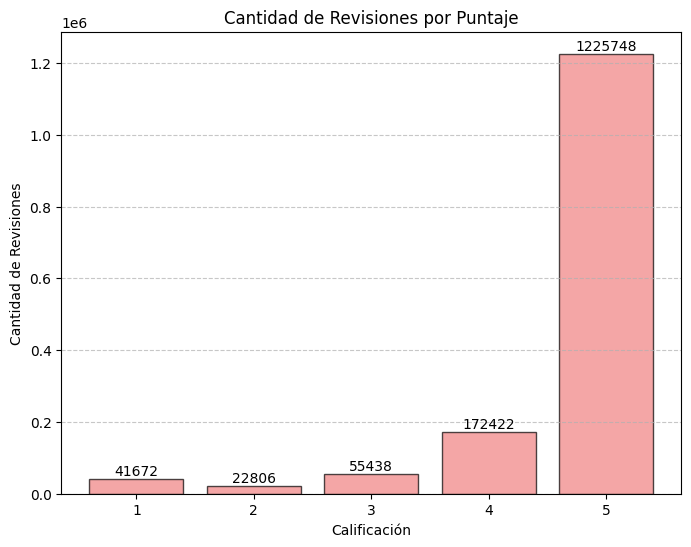

In [14]:
# Selecciona la columna 'overall' y convierte a Pandas
overall_data = df.select("overall").toPandas()

# Calcular la cantidad de revisiones por puntaje
ratings_counts = overall_data["overall"].value_counts().sort_index()

# Crear un histograma con etiquetas
plt.figure(figsize=(8, 6))
plt.bar(ratings_counts.index, ratings_counts.values, color="lightcoral", alpha=0.7, edgecolor="k")
plt.title("Cantidad de Revisiones por Puntaje")
plt.xlabel("Calificación")
plt.ylabel("Cantidad de Revisiones")
plt.xticks(ratings_counts.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Agregar etiquetas en las barras
for x, y in zip(ratings_counts.index, ratings_counts.values):
    plt.text(x, y, str(y), ha="center", va="bottom")

plt.show()

Podemos observar la distinta frecuencia de votos y su cantidad, siendo algo para notar que la gente prefiere votar 5 estrellas o no votar antes que dar una calificacion baja, concluimos esto debido a la gran diferencia de valoraciones que hay

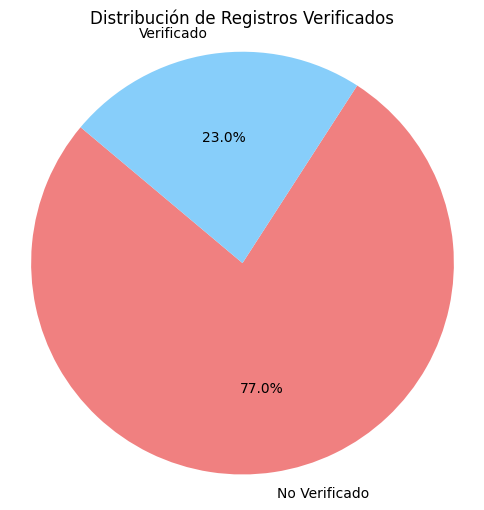

In [15]:
verified_counts = df.groupBy('verified').count().collect()

# Extrae los valores de la cuenta para cada categoría
labels = ['No Verificado', 'Verificado']
counts = [row['count'] for row in verified_counts]

# Trazar el gráfico de pastel utilizando Matplotlib
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightskyblue'])
plt.title('Distribución de Registros Verificados')
plt.axis('equal')  # Para que el gráfico sea un círculo en lugar de una elipse
plt.show()

Tambien podemos observar que la mayoria de las reviews no fueron por cuentas verificadas, por lo que se puede poner en duda un poco el indole de las reviews.

In [16]:
df.show()

+----------+-------+--------------------+--------------+-----------------+--------+-------------------+-----------+
|      asin|overall|          reviewText|    reviewerID|     reviewerName|verified|        review_date|review_year|
+----------+-------+--------------------+--------------+-----------------+--------+-------------------+-----------+
|B000V6AEI6|    5.0|The composistions...| AAVK0CAPD9XH5|             mole|   false|2003-12-31 21:00:00|       2003|
|B000VRWV4U|    5.0|I needed some sca...|A3O39R049OZZUZ|            Wonka|    true|2012-12-31 21:00:00|       2012|
|B000TE3FBS|    1.0|never received it...| A19CD6KQG33SD|            Dixie|    true|2013-12-31 21:00:00|       2013|
|B0048W3SQ4|    5.0|WHAT ELSE CAN YOU...|A1WHQ7EFI717UH|   JOHNWAYNEFAN57|    true|2013-01-09 21:00:00|       2013|
|B0011W0BKA|    5.0|use this for our ...|A2JTT6E8TMNUIG|   Family of Five|    true|2013-01-10 21:00:00|       2013|
|B003G8WI7G|    5.0|Trombone Shorty's...|A3K9WWU19MSZ41|      CommonCent

## Paso 7: Analisis de sentimiento
---
En este paso crearemos una columna que calificara el sentimiento de la columna reviewText y nos devolvera la conformidad del usuario con el producto.